<a href="https://colab.research.google.com/github/NsiriRoua/tensor_flow/blob/main/Energy_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.


# **Imports**

In [1]:
try:
  %tensorflow_version 22.x
except Exception:
  pass

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `22.x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from sklearn.model_selection import train_test_split

# **Functions**

In [6]:
def format_output(data):
  y1=data.pop('Y1')
  y1=np.array(y1)
  y2=data.pop('Y2')
  y2=np.array(y2)
  return y1,y2

def norm(x):
  return (x -train_stats['mean'])/train_stats['std']

def plot_diff(y_true,y_pred,title=''):
  plt.scatter(y_true,y_pred)
  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100, 100])
  plt.show()

def plot_metrics(metric_name,title,ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
  plt.show()



# **Prepare the Data**

In [19]:
#Get the data from UCI dataset
URL='https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'


In [20]:

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# **Let's build the model**

In [36]:
#Define model layers
input_layer=Input(shape=(len(train.columns)))
first_dense=Dense(units=128,activation='relu')(input_layer)
second_layer=Dense(units=128,activation='relu')(first_dense)
#Y1 will be fed directly from the second Dense
y1_output=Dense(units=1,name='y1_output')(second_layer)
#Now, let's define the third layer
third_dense=Dense(units=64,activation='relu')(second_layer)
y2_output=Dense(units=1,name='y2_output')(third_dense)


In [37]:
#Now, let's define the model 
model=Model(inputs=input_layer,outputs=[y1_output,y2_output])

In [38]:
#Let's see the summary 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          1152        input_5[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          16512       dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           8256        dense_12[0][0]                   
____________________________________________________________________________________________

# **Let's compile**

In [39]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})


# **Fit the model**

In [40]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 7ms/step - loss: 582.0803 - y1_output_loss: 283.2912 - y2_output_loss: 298.7891 - y1_output_root_mean_squared_error: 16.2394 - y2_output_root_mean_squared_error: 16.5703 - val_loss: 33.2780 - val_y1_output_loss: 13.8401 - val_y2_output_loss: 19.4379 - val_y1_output_root_mean_squared_error: 3.7202 - val_y2_output_root_mean_squared_error: 4.4088
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 30.7155 - y1_output_loss: 11.7578 - y2_output_loss: 18.9577 - y1_output_root_mean_squared_error: 3.4045 - y2_output_root_mean_squared_error: 4.3166 - val_loss: 26.4128 - val_y1_output_loss: 9.5425 - val_y2_output_loss: 16.8704 - val_y1_output_root_mean_squared_error: 3.0891 - val_y2_output_root_mean_squared_error: 4.1074
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 25.9426 - y1_output_loss: 9.5964 - y2_output_loss: 16.3461 - y1_output_root_mean_squared_error: 3.0954 - y2_output_root_mean_squa

# **Let's evaluate our Model**

In [42]:
loss,Y1_loss,Y2_loss,Y1_rmse,Y2_rmse=model.evaluate(x=norm_test_X,y=test_Y)
print("Loss={},Y1_loss={},Y2_loss={},Y1_rmse={},Y2_rmse={}".format(loss,Y1_loss,Y2_loss,Y1_rmse,Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 1.0155 - y1_output_loss: 0.1449 - y2_output_loss: 0.8706 - y1_output_root_mean_squared_error: 0.3807 - y2_output_root_mean_squared_error: 0.9330
Loss=1.0154750347137451,Y1_loss=0.1449081003665924,Y2_loss=0.8705670237541199,Y1_rmse=0.38066795468330383,Y2_rmse=0.9330418109893799


# **Let's plot the metrics**

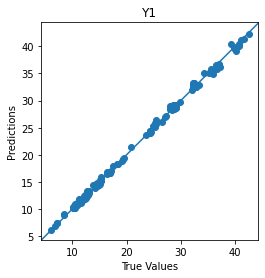

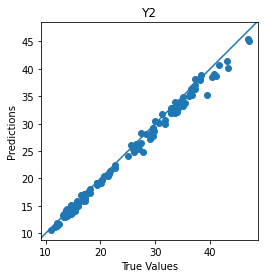

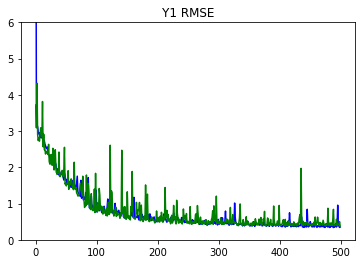

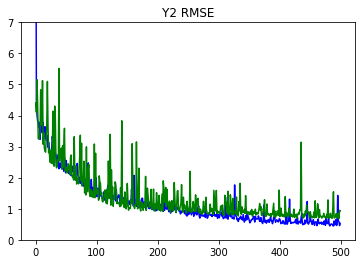

In [44]:
Y_pred=model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)
